In [18]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Abreu, T., Silva, P.A., Sancho, F., and Temperville (2010) 
  Analytical approximate wave form for asymmetric waves. 
  Coastal Engineering, 57(7):656-667.
  doi: http://dx.doi.org/10.1016/j.coastaleng.2010.02.005.

Malarkey, J. and A. G. Davies (2012) Free-stream velocity descriptions 
  under waves with skewness and asymmetry.
  Coastal Engineering, 68:78-95.
  doi: http://dx.doi.org/10.1016/j.coastaleng.2012.04.009.
  
Ruessink, B. G., G. Ramaekers, and L. C. van Rijn (2012)
  On the parameterization of the free-stream non-linear wave orbital 
  motion in nearshore morphodynamic models. Coastal Engineering, 6556-63.
  doi: http://dx.doi.org/10.1016/j.coastaleng.2012.03.006.
  
van Rijn, L. C., P. K. Tonnon, and D. J. R. Walstra (2011)
  Numerical modelling of erosion and accretion of plane sloping beaches 
  at different scales. Coastal Engineering, 58: 637-655. 
  doi: http://dx.doi.org/10.1016/j.coastaleng.2011.01.009.


<h3>Functions for calculating wave assymetry</h3>

In [16]:
def ursell( Hs, T, h ):
    """
    Calculate Ursell number
    Reussink et al. Eqn 6.
    """
    w = 2*np.pi/T
    kh = qkhfs(w,h)
    k = kh/h
    Ur =0.75*0.5*Hs*k/(kh)**3.
    return Ur

def qkhfs( w, h ):
    """
    Quick iterative calculation of kh in gravity-wave dispersion relationship
    kh = qkhfs(w, h )
    
    Input
        w - angular wave frequency = 2*pi/T where T = wave period [1/s]
        h - water depth [m]
    Returns
        kh - wavenumber * depth [ ]

    Orbital velocities from kh are accurate to 3e-12 !

    RL Soulsby (2006) \"Simplified calculation of wave orbital velocities\"
    HR Wallingford Report TR 155, February 2006
    Eqns. 12a - 14
    """
    g = 9.81
    x = w**2.0 *h/g
    y = np.sqrt(x) * (x<1.) + x *(x>=1.)
    # is this faster than a loop?
    t = np.tanh( y )
    y = y-( (y*t -x)/(t+y*(1.0-t**2.0)))
    t = np.tanh( y )
    y = y-( (y*t -x)/(t+y*(1.0-t**2.0)))
    t = np.tanh( y )
    y = y-( (y*t -x)/(t+y*(1.0-t**2.0)))
    kh = y
    return kh

def ruessink_assym( Ur ):
    """
    Calculate assymetry parameters from Ursell number
    rp = ruessink_assym( Ur )
    Ruessink et al., 2012, Coastal Engineering 65:56-63.
    """
    dtr = np.pi/180.
    # Calculate B and phi from RRvR p. 58
    p1 = 0.
    p2 = 0.857
    p3 = -0.471
    p4 = 0.297
    #B = p1 + (p2 - p1)/(1 + exp( (p3-log(Ur))/p4 )) # RRvR Eqn. 9
    B = p1 + (p2 - p1)/(1 + np.exp( (p3-np.log10(Ur))/p4 )) # RRvR Eqn. 9, log10 per S. Suttles

    p5 = 0.815
    p6 = 0.672
    psi = dtr*(-90.) + dtr*90. * np.tanh(p5/(Ur**p6))  # RRvR Eqn. 10.
    # b can be used directly in MD equations
    b = np.sqrt(2.)*B/(np.sqrt(B**2+9.)) # Solution to RRvR Eqn. 11
    r = 2.*b/(b**2+1.)
    phi = -psi-np.pi/2.                                # RRvR Eqn. 12
    # dimensionless velocity and acceleration skewness
    # RRvR Eqn. 5 and MD Eqn 4a,b
    Su = B*np.cos(psi)
    Au = B*np.sin(psi)
    return (r,phi,Su,Au)

def abreu_pts(r, phi, Uw, T ):
    """
    Calculate umax, umin, and phases of assymetrical wave orbital velocity
    af = abreu_pts( r, phi, Uw, T )
    
    Input:
      r and phi - assymetry parameters from Ruessink et al.
      Uw - amplitude of orbital velocity (m/s)
      T  - wave period
    
    Returned:
       T  - wave period (s) 
       DTc  - duration under crest (s)
       DTt  - duration under trough (s)
        (T = DTc + DTt)
       DTcu - duration of acceleration under crest (s)
       DTtu - duratin of acceleration under trough (s)
       Tzd  - time of zero down-crossing (s)
       Tzu  - time of zero up-crossing (s)
       Tc   - time of maximum velocity under crest (s)
       Tt = - time of minimum velocity under trough (s)
       umax - maximum velocity under crest (m/s)
       umin - minimum velocity under trough (m/s)
       R  - Velocity skewness parameter == umax/(umax-umin) ()
       Beta - Acceleration skewness parameter == amax/(amax-amin) ()
       Sk - van Rijn et al. 2011 (Eqn 2) assymetry statistic ()
       As - van Rijn et al. 2011 (Eqn 2) assymetry statistic ()
    """
    w = 2*np.pi/T

    # alternative formulation Eqns 16a,b in Malarkey & Davies
    phi = -phi
    P = np.sqrt(1.-r*r) # same as f
    b = r/(1.+P)

    # Appendix E of Malarkey & Davies
    # phase of umax (crest) and umin (trough) (in radians, from 0 to 2*pi)
    c = b*np.sin(phi)
    tmc = np.arcsin((4.*c*(b*b-c*c)+(1.-b*b)*(1.+b*b-2.*c*c))/((1.+b*b)**2-4.*c*c))
    tmt = np.arcsin((4.*c*(b*b-c*c)-(1.-b*b)*(1.+b*b-2.*c*c))/((1.+b*b)**2-4.*c*c))
    if(tmt<0.):
       tmt = tmt+2.*np.pi

    if(tmc<0.):
       tmc = tmc+2*np.pi

    # umax and umin - non dimensional
    umax = 1.+c;
    umin = umax-2.
    # dimensional
    umax = Uw*umax
    umin = Uw*umin

    # phase of zero upcrossing and downcrossing (radians)
    tzu = np.arcsin(b*np.sin(phi)) # = arcsin(c)
    tzd = 2.*np.arccos(c)+tzu

    # Calculate assymetry parameters R and Beta
    # R = umax/(umax-umin) % gives same result as:
    R = 0.5*(1.+ b*np.sin(phi) ) # MD Eqn 17
    # after MD Eqn. 18
    Fo = (r<=.5) * (1.-0.27*(2.*r)**2.1) + \
     (r> .5) * (0.59 + 0.14*(2.*r)**-6.2)
    # MD Eqn. 15b
    Br0 =(r< 0.5)* (0.5*(1+r)) + \
     (r>=0.5)* ( 4.*r*(1.+r)/(4.*r*(1.+r)+1.) )
    Beta = 0.5+(Br0-0.5)*np.sin(0.5*np.pi-np.abs(phi))*Fo/np.sin(0.5*np.pi*Fo)
  
    # Calculate assymetry parameters Sk and As (same as van Rijn et al. 2011 Eqn. 2)
    Sk =  3.*b*np.sin(phi)/np.sqrt(2.*(1.+b**2))**3
    As = -3.*b*np.cos(phi)/np.sqrt(2.*(1.+b**2))**3

    # (Could also use MD Appendix C to calculate uspike, aspike, and other
    # measures of assymetry.)

    # These are the dimensional fractions of wave periods needed by Van der A eqn.
    DTc  = (tzd-tzu)/w
    DTt  = T - DTc
    DTcu = (tmc-tzu)/w
    DTtu = (tmt-tzd)/w
    Tzd = (tzd)/w
    Tzu = (tzu)/w
    Tc =  (tmc)/w
    Tt  = (tmt)/w
    return {'T':T, 'DTc':DTc, 'DTt':DTt, 'DTcu':DTcu, 'DTtu':DTtu, \
            'Tzd':Tzd, 'Tzu':Tzu,'Tc':Tc,'Tt':Tt, \
            'umax':umax,'umin':umin,'R':R,'Beta':Beta,'Sk':Sk,'As':As}

def abreu_ut ( r, phi, Uw, T, iplot=0, n=50):
    """
    Calculate u(t) and a(t) using Abreu et al. (2010) eqn. 7
    """
    w = 2.*np.pi/T
    wt = np.linspace( 0., 2.*np.pi, n) # phase
    f = np.sqrt( 1. - r**2 )
    numer = np.sin(wt) + ( r*np.sin(phi)/(1.+np.sqrt(1.-r**2)) )
    denom = (1.-r*np.cos(wt+phi))
    ut = Uw*f*numer/denom
    numer2 = np.cos(wt)-r*np.cos(phi)-r**2/(1.+np.sqrt(1.-r**2))*np.sin(phi)*np.sin(wt+phi)
    at = Uw*w*f*numer2/denom**2
    # dimensional values
    t = wt/w
    u = Uw*ut
    a = Uw*w*at
    
    if iplot:
        #plot time series of velocity and acceleration
        plt.plot(t,a,linewidth=2,color='firebrick',label='Acceleration')    
        plt.plot(t,u,linewidth=2,color='cornflowerblue',label='Velocity');
        plt.ylabel('u (m/s); du/dt (m/s^2)')
        plt.xlabel('Time (s)')

        # find critical points and plot
        af = abreu_pts( r, phi, Uw, T )
        plt.plot(af['Tc'],af['umax'],marker='^',color='blue',label='umax')
        plt.plot(af['Tt'],af['umin'],marker='v',color='red',label='umin')
        plt.plot([ af['Tzu'], af['Tzu']+af['DTc']],[-1.2, -1.2],linewidth=4,color='blue',label='crest');
        plt.plot([ af['Tzd'], af['Tzd']+af['DTt']],[-1.2, -1.2],linewidth=4,color='red',label='trough');
        plt.plot([ af['Tzu'], af['Tzu']+af['DTcu']],[-1.1, -1.1],linestyle=':',linewidth=4,color='blue',label='accel');
        plt.plot([ af['Tzd'], af['Tzd']+af['DTtu']],[-1.1, -1.1],linestyle=':',linewidth=4,color='red',label='decel');
        plt.legend()    
    return wt, ut, at

<h3>Example of wave assymetry calculations</h3>

0.204142244008
0.0414046793529 -1.57078859304 0.0439398447143 -3.3981984038e-07


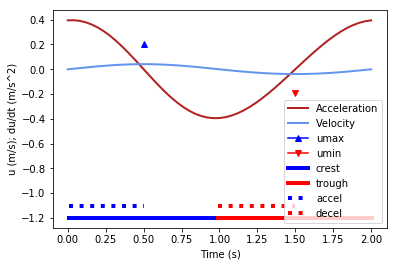

In [21]:
# The assymetry depends only on depth h, significant wave height Hs,
# and dominant period Td.
h =  1.05
Hs = .2
Td = 2.

# Note on Uw...this scales the velocity time series. For monochromatic 
# waves, it is equal to the amplitude of the sine wave, but for
# wave spectra, it probably has to be related to the RMS value.
Uw = .2

# The assymetry parameters only depend on the Ursell number
# (these are returned as a tuple, so the order of return values matters)
r, phi, Su, Au = ruessink_assym( ursell( Hs, Td, h ) )

# The key points over the wave cycle required for subsequent transport calcs
# is provided by abreu_pts. Results are returned as dict because there are a
# alot to keep track of.
af = abreu_pts(r, phi, Uw, Td )
# The values can be accessed by their names:
print( af['umax'])

# Call abreu_ut to get dimensional time series of velocities and 
# acceleration over the time series. Use iplot=1 to make a graph with n points.
wt,ut,at=abreu_ut ( r, phi, Uw, Td, iplot=1, n=51)
print(r,phi,Su,Au)

<h3>Functions for sediment transport</h3>

In [ ]:
def soulsby_ws( D, rhos=2650., rhow=1027., nu=1.36e-6 ):
    """
    Calculate settling velocity for sand
    Input:
        D - grain size (m)
        rhos - sediment density (kg/m3; optional, default = 2650)
        rhow - water density (kg/m3; optional, default = 1027)
        nu - kinematic viscosity (m2/s; optional, default = 1.36e-6)
    Returns:
        ws - settling velocity (m/s)
        
    Soulsby, 1997, p. 132 - 137
    """
    g = 9.81
    s = rhos/rhow
    Dstar = D*((g*(s-1.))/(nu*nu))**(1./3.)                 # eqn. 98
    ws = (nu/D)*( sqrt(10.36**2+1.049*Dstar**3.) - 10.36 )  # eqn. 102
    return ws

def soulsby_theta_crit( d, rhos=2650., rhow=1027., nu= 1.36e-6):
    """
    Critcal Shields number  (MKS units)
    theta_crit = soulsby_theta_crit( d, rhos, rhow, nu )
    
    Input (MKS units):
      d - diameter (m)
      rhos - sediment density (optional, default = 2650 kg/m3)
      rhow - water density (optional, default = 1027 kg/m3)
      nu   - kinematic viscosity (optional, default = 1.36e-6 m2 s-1)
      
    From Soulsy (1997) 'Dynamics of Marine Sands'

    csherwood@usgs.gov
    last revised March, 2015
    """
    g = 9.81                                                         # m s-2
    s = rhos/rhow                                                    # p. 104
    Dstar = d*(g*(s-1.)/(nu**2.))**(1./3.)                           # Eqn 75
    Shields_crit = 0.3/(1.+1.2*Dstar) + 0.055*(1.-exp(-0.020*Dstar)) # Eqn 77
    return Shields_crit

def od_ripple( d50, Psi ):
    """
    Calculate 0'Donoghue et al. (2006) ripple geometry
    Input:
        d50 - median grain size (m)
        Psi - mobility number, max of crest or trough flow
    Returns:
        Hoa - ripple height normalized by orbital amplitude A
        Hoa - ripple length normalized by orbital amplitude A   
    
    van der A et al. (2013) Appendix B.
    """
    d50mm = 1.e3*d50 #convert from m to mm
    mL = 0.73
    mH = 0.55
    if(d50mm>=0.22):
        fac = (d50mm-0.22)/(0.3-0.22)
        mH = mH+0.45*fac
        mL = mL+0.27*fac
        if(d50mm>=0.3):
            mH = 1.
            mL = 1.
    # smooth transition to upper flat bed regime   
    nH = 1.
    if(Psi>190.):
        nH = 0.5*(1.+cos( pi*(Psi-190.)/(240.-190.) ))
        if(Psi>250.):
            nH = 0.
    nL = nH
    print mH, nH, mL, nL
    Hoa = max(0., mH*nH*(0.275-0.022*Psi**0.42) )
    Loa = max(0., mL*nL*(1.97-0.44*Psi**0.21) )
    return Hoa, Loa
    
def dsf_func(d50, theta ):
    """
    Calculate sheet flow thickess
    Input:
        d50 - median grain size (m)
        Theta - maximum (crest or trough) Shields paramter
    Returns:
        dsf - thickness of sheet flow layer (m)
        
    Based on Janssen (1999) in van der A et al. (2013), Appendix C.
    See also Dohmen-Janssen et al. (2001), JGR 106(C11):27,103-27,115, Eqn. 6 & 7
    """
    d50mm = 1.e3*d50
    deln = 25.*theta
    if (d50mm > 0.15 ):
        deln = deln-12.*(d50mm-0.15)/(0.2-0.15)
        if (d50mm >= 0.2 ):
            deln = 13.*theta
    dsf=max( deln*d50, d50 ) # unstated, but assume dsf = d50 when theta = 0
    return dsf

def ksd_func( d50, d90, rh=0., rl=1.e-6, theta=0. ):
    """
    Calculate current-related bed roughess
    zo = ksd/30
    Input:
        d50 - median grain size (m)
        d90 - 90th percentile grain size (m)
        rh - ripple height (m)
        rh - ripple wavelength (m)
        theta - time-averaged absolute Shields stress
    Returns:
        ksd - roughness (m)
    
    Based on Ribberink (1998) in van der A et al. (2013), Appendix A.
    """    
    rh = max(rh,d50)
    rl = max(rl,d50) # avoid divide-by-zero
    # Eqn. A.2
    mu = 6.
    d50mm = d50*1.e3
    if( d50mm > 0.15 ):
        mu = 6. - 5.*(d50mm-0.15)/(0.2-0.15)
        if( d50mm >= 0.2 ):
            mu = 1.
    # eqn A.1
    ksd = max(3.*d90, d50*(mu+6.*(theta-1.))) + 0.4*rh*rh/rl
    return ksd

def ksw_func( d50, rh=0., rl=1.e-6, theta=0. ):
    """
    Calculate wave roughess
    Input:
        d50 - median grain size (m)
        rh - ripple height (m)
        rh - ripple wavelength (m)
        theta - time-averaged absolute Shields stress
    Returns:
        ksw - roughness (m)
    
    Based on Ribberink (1998) in van der A et al. (2013), Appendix A.
    """    
    rh = max(rh,d50)
    rl = max(rl,d50) # avoid divide-by-zero
    # Eqn. A.2
    mu = 6.
    d50mm = d50*1.e3
    if( d50mm > 0.15 ):
        mu = 6. - 5.*(d50mm-0.15)/(0.2-0.15)
        if( d50mm >= 0.2 ):
            mu = 1.

    # eqn A.5
    ksw = max(d50, d50*(mu+6.*(theta-1.))) + 0.4*rh*rh/rl
    return ksw

def fw_func(ahat,ksw):
    fw = 0.3
    aksw = ahat/ksw
    if aksw > 1.587:
        fw = 0.00251*exp(5.21*aksw**(-0.19))  # Eqn. A4, A5
    return fw

def fd_func( dsf, ksd ):
    vk = 0.41
    fd = 2.*(vk/log(30.*dsf/ksd))**2.          # Eqn. 20
    return fd               

In [ ]:
# Van der A et al. (2013) Sand Transport Formula
eps = 1.e-8
g = 9.81
rhow = 1027.
nu = 1.36e-6
# Sediment parameters
d50 = 0.15e-3
d90 = 1.5*d50 # check this...van Rijn has an eqn.
rhos = 2650.
s = (rhos-rhow)/rhow # van der A, after Eq. 1 on p. 27
# but I think it should be:
s = rhos/rhow

ws = soulsby_ws(d50, rhos, rhow, nu)
# settling velocity for suspended fraction, assumed to have diameter 0.8 * D50
wss = soulsby_ws(0.8*d50, rhos, rhow, nu)

# rc, rt are representative flow height at under crest and trough
# and is determined by flow regime
# uw_min is peak negative vertical velocity at r
# uw_max is peak positive vertical velocity
rc = 
wsc = wss-uw_min
wst = wss+uw_max

theta_crit = soulsby_theta_crit(d50, rhos, rhow, nu)
tau_crit = theta_crit * (g*(rhos-rhow)*d50 ) # Soulsby Eqn 74 (inverse)
print "Soulsby ws for D=",1000.*d50," mm is ",1000.*ws," mm/s."
print "Soulsby theta_crit is ", theta_crit," []; tau_crit = ",tau_crit," Pa."
            
# Wave statistics
Hs = 2.
h = 4.
u
T = 10. # = Tp, peak wave period (s)
uhat = 0.5 # "significant" orbital velocity (ubr = ubot, or sqrt(2) times that?
ahat = uhat*T/(2.*pi)

# Current
mag_u_d = 0.1

# Max. mobility number (Appdx. B) for irregular waves...but want to use max(crest, trough) later
Psi = (1.27*uhat)**2. / ((s-1.)*g*d50)
Hoa, Loa = od_ripple( d50, Psi ) # mean flow not involved in ripple geometry
print "Hoa, Loa: ",Hoa,Loa
rh = Hoa*ahat
rl = Loa*ahat
print 'rh, rl:',rh, rl

dsf = d50 # first guess: no sheet flow layer
ksw = ksw_func( d50, rh, rl, 0. )
ksd = ksd_func( d50, d90, rh, rl, 0. )

tlast = 999.
acc = 99.
tol = 1e-3
nit = 20
i = 0
sf = 1./((s-1.)*g*d50)
while (i<nit and (abs(acc)>tol) ):
    fw = fw_func( ahat, ksw )
    fd = fd_func(  dsf, ksd )
    mean_mag_theta = sf*(0.5*fd*mag_u_d**2. + 0.25*fw*uhat**2. )
    acc = 2.*(tlast-mean_mag_theta)/(eps+tlast+mean_mag_theta)
    tlast = mean_mag_theta
    print ("{0:2d} fd={1:6.4f} fw={2:6.4f} theta={3:6.3f} acc={4:6.4f}"+\
          " dsf={5:6.4f} ksw={6:6.4f} ksd={7:6.4f}")\
    .format( i, fd, fw, mean_mag_theta, acc, dsf, ksw, ksd)
    dsf = dsf_func( d50, mean_mag_theta )
    ksw = ksw_func( d50, rh, rl, mean_mag_theta )
    ksd = ksd_func( d50, d90, rh, rl, mean_mag_theta )    
    i=i+1


## Effect of Wave Shoaling on Assymetry

In [ ]:
g=9.81
T = 12.
H0 = 1.
slope = -1.e-3
h = linspace(10., 1., 10)
x = h/slope
kh = zeros_like(h)
k = zeros_like(h)
n = zeros_like(h)
C = zeros_like(h)
HoH=zeros_like(h)
H  =zeros_like(h)
Ur =zeros_like(h)
b = zeros_like(h)
p = zeros_like(h)
w = 2.*pi/T
C0 = g/w
print "h=",h,"C0=",C0
for i in xrange(len(h)):
    kh[i]=qkhfs( w, h[i])
    k[i]=kh[i]/h[i]
    n[i]=0.5*(1.+2*kh[i]/sinh(2*kh[i]))
    C[i]=g/w*tanh(kh[i])
    HoH[i]=sqrt((1./(2.*n[i]))*C0/C[i])
    H[i] = H0*HoH[i]
    Ur[i] = ursell( H[i]/2., k[i], h[i])
    B = Bfit( Ur[i] )
    P = Phifit( Ur[i] )
    b[i] = sqrt(2.)*B/(sqrt(B**2+9.)) # use directly in M&D formula
    p[i] -P
    print i, x[i],kh[i], n[i],HoH[i],Ur[i],b[i],p[i]
    
fig = plt.figure(figsize(12,8))
plt.subplot(3,2,1)
plot(x,Ur)
plt.ylabel("Ursell No.")
plt.subplot(3,2,3)
plot(x,H)
plt.ylabel('H (m)')
plt.subplot(3,2,5)
plt.ylabel('Depth (m)')
plot(x,-h)
xlabel("Offshore Distance (m)")
plt.subplot(3,2,2)
plot(x,b)
plt.ylabel('b')
plt.subplot(3,2,4)
plt.ylabel('$\phi$ (radians)')
plot(x,p)
savefig("shoaling.png")

In [ ]:
# calculate effective settling velocity in crest and trough
# Settling velocity for suspended sediment fraction
wss = 

In [ ]:
# transport parameter coefficients
m = 
n =
vk = 0.41
uhat = 

u_cr_mag = 
u_tr_mag = 

# calculate current-related roughness following Ribberink (1998) in Appx. A.
d50mm = d50*1000.
if(d50<=0.15e-3): 
    coeff = 6.
elif(d50>0.15e-3 & d50<

# Roughness for half-wave cycles Eqn. 21
ksw = 
c1 =2.6 
fw_c = 0.3
if( askw > 1.587 ):
    fw_c = 0.00251*exp( 5.21*((( 2.*Tcu/Tc )**c1)*ahat/ksw)**(-0.19) )
fw_t = 0.3
if( askw > 1.587 ):
    fw_t = 0.00251*exp( 5.21*((( 2.*Ttu/Tt )**c1)*ahat/ksw)**(-0.19) )
    
mean_mag_theta 
ksd = max( 3.*d90, d50*(rmu+6.*(mean_mag_theta-1.) ) + 0.4*rh**2./rl
# current friction factor assumes log profile Eqn. 20
fd = 2.*(vk/log( 30*d/(ksd))**2.

# friction factor (crest and trough) is linear combination of wave and current fric. factors
# Eqn. 19 and 18
alp = mag_u_d/(mag_u_d + uhat)
fwdc = alp*fd + (1.-alp)*fw_c
fwdt = alp*fd + (1.-alp)*fw_t

sf = 1./((s-1.)*g*d50)
theta_c_mag = sf*0.5*fwdc*u_cr_mag**2.
theta_t_mag = sf*0.5*fwdt*u_tr_mag**2.

theta_cx = theta_c_mag*u_crx/u_cr_mag + tauterm 
theta_cy = theta_c_mag*u_cry/u_cr_mag

theta_tx = theta_t_mag*u_trx/u_tr_mag + tauterm 
theta_ty = theta_t_mag*u_try/u_tr_mag

omega_c = 0.
if( abs(theta_c) > theta_crit ):
    omega_c = m*(abs(theta_c)-theta_crit)**n
omega_tt = 0.
if( abs(theta_t) > theta_crit ):
    omega_t = m*(abs(theta_t)-theta_crit)**n
# Eqn. 1
Phibar = (1./T)*
   ( sqrt( abs( theta_c ) )*Tc*(Omega_cc+(Tc/(2.*Tcu))*Omega_tc)*(theta_c/abs(theta_c)) +
     sqrt( abs( theta_t ) )*Tt*(Omega_tt+(Tt/(2.*Ttu))*Omega_ct)*(theta_t/abs(theta_t)) )